In [1]:
import numpy as np
import pandas as pd
from scipy import sparse
import xgboost as xgb
from itertools import product
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn import model_selection,ensemble
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import random
from sklearn_pandas import DataFrameMapper
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, Imputer, LabelBinarizer, MultiLabelBinarizer,LabelEncoder
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# index=list(range(train_df.shape[0]))
# random.shuffle(index)
# a=[np.nan]*len(train_df)
# b=[np.nan]*len(train_df)
# c=[np.nan]*len(train_df)

# for i in range(5):
#     building_level={}
#     count={}
#     for j in train_df['manager_id'].values:
#         building_level[j]=[0,0,0]
#         count[j]=[0,0,0]
#     test_index=index[int((i*train_df.shape[0])/5):int(((i+1)*train_df.shape[0])/5)]
#     train_index=list(set(index).difference(test_index))
#     for j in train_index:
#         temp=train_df.iloc[j]
#         if temp['interest_level']=='low':
#             building_level[temp['manager_id']][0]+=temp['price']
#             count[temp['manager_id']][0]+=1
#         if temp['interest_level']=='medium':
#             building_level[temp['manager_id']][1]+=temp['price']
#             count[temp['manager_id']][1]+=1
#         if temp['interest_level']=='high':
#             building_level[temp['manager_id']][2]+=temp['price']
#             count[temp['manager_id']][2]+=1
#     for j in test_index:
#         temp=train_df.iloc[j]
#         if count[temp['manager_id']][0]!=0:
#             a[j]=building_level[temp['manager_id']][0]*1.0/count[temp['manager_id']][0]
#         if count[temp['manager_id']][1]!=0:
#             b[j]=building_level[temp['manager_id']][1]*1.0/count[temp['manager_id']][1]
#         if count[temp['manager_id']][2]!=0:
#             c[j]=building_level[temp['manager_id']][2]*1.0/count[temp['manager_id']][2]
# train_df['manager_price_low']=a
# train_df['manager_price_medium']=b
# train_df['manager_price_high']=c


# a=[]
# b=[]
# c=[]
# building_level={}
# count={}
# for j in train_df['manager_id'].values:
#         building_level[j]=[0,0,0]
#         count[j]=[0,0,0]
# for j in range(train_df.shape[0]):
#     temp=train_df.iloc[j]
#     if temp['interest_level']=='low':
#         building_level[temp['manager_id']][0]+=temp['price']
#         count[temp['manager_id']][0]+=1
#     if temp['interest_level']=='medium':
#         building_level[temp['manager_id']][1]+=temp['price']
#         count[temp['manager_id']][1]+=1
#     if temp['interest_level']=='high':
#         building_level[temp['manager_id']][2]+=temp['price']
#         count[temp['manager_id']][2]+=1

# for i in test_df['manager_id'].values:
#     if i not in building_level.keys():
#         a.append(np.nan)
#         b.append(np.nan)
#         c.append(np.nan)
#     else:
#         if count[i][0]!=0:
#             a.append(building_level[i][0]*1.0/count[i][0])
#         else:
#             a.append(np.nan)
#         if count[i][1]!=0:
#             b.append(building_level[i][1]*1.0/count[i][1])
#         else:
#             b.append(np.nan)
#         if count[i][2]!=0:
#             c.append(building_level[i][2]*1.0/count[i][2])
#         else:
#             c.append(np.nan)
# test_df['manager_price_low']=a
# test_df['manager_price_medium']=b
# test_df['manager_price_high']=c


# features_to_use.append('manager_price_low') 
# features_to_use.append('manager_price_medium') 
# features_to_use.append('manager_price_high')

In [12]:
def cv_train(train,y):
    xgtrain = xgb.DMatrix(train, label=y)
    params = dict()
    params['objective']='multi:softprob'
    params['eval_metric']='mlogloss',
    params['num_class']=3
    params['silent']=0
    params['eta'] = 0.3
    params['verbose_eval'] = False
    params['max_depth'] = 6


    cv_result = xgb.cv(
        params, xgtrain, 
        num_boost_round=10000, nfold=5,
        metrics = 'mlogloss',
        seed=0,callbacks=[xgb.callback.early_stop(20)]
    )

    return cv_result['test-mlogloss-mean'].values[-1]

In [4]:
def CV_st(train,test,feature1,feature2):
    index=list(range(train.shape[0]))
    random.shuffle(index)
    a=[np.nan]*len(train)
    b=[np.nan]*len(train)
    c=[np.nan]*len(train)

    for i in range(5):
        building_level={}
        count={}
        for j in train[feature1].values:
            building_level[j]=[0,0,0]
            count[j]=[0,0,0]
        test_index=index[int((i*train.shape[0])/5):int(((i+1)*train.shape[0])/5)]
        train_index=list(set(index).difference(test_index))
        for j in train_index:
            temp=train.iloc[j]
            if temp['interest_level']=='low':
                building_level[temp[feature1]][0]+=temp[feature2]
                count[temp[feature1]][0]+=1
            if temp['interest_level']=='medium':
                building_level[temp[feature1]][1]+=temp[feature2]
                count[temp[feature1]][1]+=1
            if temp['interest_level']=='high':
                building_level[temp[feature1]][2]+=temp[feature2]
                count[temp[feature1]][2]+=1
        for j in test_index:
            temp=train.iloc[j]
            if count[temp[feature1]][0]!=0:
                a[j]=building_level[temp[feature1]][0]*1.0/count[temp[feature1]][0]
            if count[temp[feature1]][1]!=0:
                b[j]=building_level[temp[feature1]][1]*1.0/count[temp[feature1]][1]
            if count[temp[feature1]][2]!=0:
                c[j]=building_level[temp[feature1]][2]*1.0/count[temp[feature1]][2]
            
    train[feature1 + '_' + feature2 + '_low']=a
    train[feature1 + '_' + feature2 + '_medium']=b
    train[feature1 + '_' + feature2 + '_high']=c

    a=[]
    b=[]
    c=[]
    building_level={}
    count={}
    
    for j in train[feature1].values:
        building_level[j]=[0,0,0]
        count[j]=[0,0,0]
    for j in range(train.shape[0]):
        temp=train.iloc[j]
        if temp['interest_level']=='low':
            building_level[temp[feature1]][0]+=temp[feature2]
            count[temp[feature1]][0]+=1
        if temp['interest_level']=='medium':
            building_level[temp[feature1]][1]+=temp[feature2]
            count[temp[feature1]][1]+=1
        if temp['interest_level']=='high':
            building_level[temp[feature1]][2]+=temp[feature2]
            count[temp[feature1]][2]+=1

    for i in test[feature1].values:
        if i not in building_level.keys():
            a.append(np.nan)
            b.append(np.nan)
            c.append(np.nan)
        else:
            if count[i][0]!=0:
                a.append(building_level[i][0]*1.0/count[i][0])
            else:
                a.append(np.nan)
            if count[i][1]!=0:
                b.append(building_level[i][1]*1.0/count[i][1])
            else:
                b.append(np.nan)
            if count[i][2]!=0:
                c.append(building_level[i][2]*1.0/count[i][2])
            else:
                c.append(np.nan)

    test[feature1 + '_' + feature2 + '_low']=a
    test[feature1 + '_' + feature2 + '_medium']=b
    test[feature1 + '_' + feature2 + '_high']=c

    features_tmp = []
    features_tmp.append(feature1 + '_' + feature2 + '_low') 
    features_tmp.append(feature1 + '_' + feature2 + '_medium') 
    features_tmp.append(feature1 + '_' + feature2 + '_high')

    print feature1,' vs ', feature2,'Done!'
    return train,test,features_tmp

In [2]:
#input data
train_df=pd.read_json('../input/train.json').reset_index(drop = True)
test_df=pd.read_json('../input/test.json').reset_index(drop = True)
test_df.loc[test_df.bathrooms == 112.0,'bathrooms'] = 1.5    
test_df.loc[test_df.bathrooms == 20.0,'bathrooms'] = 2.0
test_df.loc[test_df.listing_id == 7220763,'bedrooms'] = 3
test_df.loc[test_df.listing_id == 7047074,'bedrooms'] = 6
print train_df.shape
print test_df.shape

(49352, 15)
(74659, 14)


In [6]:
def add_features(df):
    fmt = lambda s: s.replace("\u00a0", "").strip().lower()
    df["num_photo_count"] = df["photos"].apply(len)
    df["street_address"] = df['street_address'].apply(fmt)
    df["display_address"] = df["display_address"].apply(fmt)
    df["num_desc_wordcount"] = df["description"].apply(len)
    df["num_pricePerBed"] = df['price'] / df['bedrooms']
    df["num_pricePerBath"] = df['price'] / df['bathrooms']
    df["num_pricePerRoom"] = df['price'] / (df['bedrooms'] + df['bathrooms'])
    df["num_bedPerBath"] = df['bedrooms'] / df['bathrooms']
    df["num_bedBathDiff"] = df['bedrooms'] - df['bathrooms']
    df["num_bedBathSum"] = df["bedrooms"] + df['bathrooms']
    df["num_bedsPerc"] = df["bedrooms"] / (df['bedrooms'] + df['bathrooms'])

    df = df.fillna(-1).replace(np.inf, -1)
    return df

# Add common features
train_df = add_features(train_df)
test_df = add_features(test_df) 

#basic features
# train_df["price_t"] =train_df["price"]/train_df["bedrooms"]
# test_df["price_t"] = test_df["price"]/test_df["bedrooms"] 
# train_df["room_sum"] = train_df["bedrooms"]+train_df["bathrooms"] 
# test_df["room_sum"] = test_df["bedrooms"]+test_df["bathrooms"] 

# count of photos #
# train_df["num_photos"] = train_df["photos"].apply(len)
# test_df["num_photos"] = test_df["photos"].apply(len)

# count of "features" #
train_df["num_features"] = train_df["features"].apply(len)
test_df["num_features"] = test_df["features"].apply(len)

# count of words present in description column #
# train_df["num_description_words"] = train_df["description"].apply(lambda x: len(x.split(" ")))
# test_df["num_description_words"] = test_df["description"].apply(lambda x: len(x.split(" ")))



train_df['num_desc_length_null'] = (train_df.description.str.len()==0).astype(float)
test_df['num_desc_length_null'] = (test_df.description.str.len()==0).astype(float)
    
features_to_use=[
#     "bathrooms", "bedrooms",  "price",
    "latitude", "longitude","num_pricePerBed",
    'num_bedBathSum','num_pricePerBath','num_pricePerRoom','num_bedPerBath',
    'num_bedBathDiff','num_bedsPerc',
    "num_photo_count", "num_features", "num_desc_wordcount",'num_desc_length_null',
    "listing_id"]

print 'Done!'

Done!


In [7]:
# Location features: Latitude, longitude
# train_df['num_latitude'] = train_df.latitude.values
# test_df['num_latitude'] = test_df.latitude.values

# train_df['num_longitude'] = train_df.longitude.values
# test_df['num_longitude'] = test_df.longitude.values
precision = 3
x = np.sqrt(((train_df.latitude - train_df.latitude.median())**2) + (train_df.longitude - train_df.longitude.median())**2)
train_df['num_dist_from_center'] = x.values
x = np.sqrt(((test_df.latitude - train_df.latitude.median())**2) + (test_df.longitude - train_df.longitude.median())**2)
test_df['num_dist_from_center'] = x.values
train_df['position'] = train_df.longitude.round(precision).astype(str) + '_' + train_df.latitude.round(precision).astype(str)
test_df['position'] = test_df.longitude.round(precision).astype(str) + '_' + test_df.latitude.round(precision).astype(str)

new_feature = ['num_dist_from_center']
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)
print 'Done!'

Done!


In [8]:
# Degree of "outlierness"
OutlierAggregated = (train_df.bedrooms > 4).astype(float)
OutlierAggregated2 = (test_df.bedrooms > 4).astype(float)
OutlierAggregated += (train_df.bathrooms > 3).astype(float)
OutlierAggregated2 += (test_df.bathrooms > 3).astype(float)
OutlierAggregated += (train_df.bathrooms < 1).astype(float)
OutlierAggregated2 += (test_df.bathrooms < 1).astype(float)
x = np.abs((train_df.price - train_df.price.median())/train_df.price.std()) > 0.30
OutlierAggregated += x.astype(float)
x2 = np.abs((test_df.price - train_df.price.median())/train_df.price.std()) > 0.30
OutlierAggregated2 += x2.astype(float)
x = np.log1p(train_df.price/(train_df.bedrooms.clip(1,3) + train_df.bathrooms.clip(1,2))) > 8.2
OutlierAggregated += x.astype(float)
x2 = np.log1p(test_df.price/(test_df.bedrooms.clip(1,3) + test_df.bathrooms.clip(1,2))) > 8.2
OutlierAggregated2 += x2.astype(float)
x = np.sqrt(((train_df.latitude - train_df.latitude.median())**2) + (train_df.longitude - train_df.longitude.median())**2) > 0.30
OutlierAggregated += x.astype(float)
x2 = np.sqrt(((test_df.latitude - train_df.latitude.median())**2) + (test_df.longitude - train_df.longitude.median())**2) > 0.30
OutlierAggregated2 += x2.astype(float)
train_df['num_OutlierAggregated'] = OutlierAggregated.values
test_df['num_OutlierAggregated'] = OutlierAggregated2.values


new_feature = ['num_OutlierAggregated']
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)
        
print 'Done!'

Done!


In [9]:
# Density in unique locations at given precision
vals = train_df['position'].value_counts()
dvals = vals.to_dict()
train_df['num_pos_density'] = train_df['position'].apply(lambda x: dvals.get(x, vals.min()))
test_df['num_pos_density'] = test_df['position'].apply(lambda x: dvals.get(x, vals.min()))

# Building null
train_df['num_building_null'] = (train_df.building_id=='0').astype(float)
test_df['num_building_null'] = (test_df.building_id=='0').astype(float)


new_feature = ['num_pos_density','num_building_null']
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)
        
print 'Done!'

Done!


In [10]:
# Creation time features
train_df['created'] = pd.to_datetime(train_df.created)
train_df['num_created_weekday'] = train_df.created.dt.dayofweek.astype(float)
train_df['num_created_weekofyear'] = train_df.created.dt.weekofyear
train_df['num_created_day'] = train_df.created.dt.day
train_df['num_created_month'] = train_df.created.dt.month
train_df['num_created_hour'] = train_df.created.dt.hour
  
test_df['created'] = pd.to_datetime(test_df.created)
test_df['num_created_weekday'] = test_df.created.dt.dayofweek
test_df['num_created_weekofyear'] = test_df.created.dt.weekofyear
test_df['num_created_day'] = test_df.created.dt.day
test_df['num_created_month'] = test_df.created.dt.month
test_df['num_created_hour'] = test_df.created.dt.hour


new_feature = ['num_created_weekday','num_created_weekofyear','num_created_day','num_created_month','num_created_hour']
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)
        
print 'Done!'

Done!


In [11]:
# Bedrooms/Bathrooms/Price
train_df['num_bathrooms'] = train_df.bathrooms.clip_upper(4)
test_df['num_bathrooms'] = test_df.bathrooms.clip_upper(4)

train_df['num_bedrooms'] = train_df.bedrooms.clip_upper(5)
test_df['num_bedrooms'] = test_df.bedrooms.clip_upper(5)

train_df['num_price'] = train_df.price.clip_upper(10000)
test_df['num_price'] = test_df.price.clip_upper(10000)

bins = train_df.price.quantile(np.arange(0.05, 1, 0.05))
train_df['num_price_q'] = np.digitize(train_df.price, bins)
test_df['num_price_q'] = np.digitize(test_df.price, bins)


new_feature = ['num_bathrooms','num_bedrooms','num_price','num_price_q']
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)
        
print 'Done!'

Done!


In [12]:
# Composite features based on: 
# https://www.kaggle.com/arnaldcat/two-sigma-connect-rental-listing-inquiries/a-proxy-for-sqft-and-the-interest-on-1-2-baths
train_df['num_priceXroom'] = (train_df.price / (1 + train_df.bedrooms.clip(1, 4) + 0.5*train_df.bathrooms.clip(0, 2))).values
test_df['num_priceXroom'] = (test_df.price / (1 + test_df.bedrooms.clip(1, 4) + 0.5*test_df.bathrooms.clip(0, 2))).values

train_df['num_even_bathrooms'] = ((np.round(train_df.bathrooms) - train_df.bathrooms)==0).astype(float)
test_df['num_even_bathrooms'] = ((np.round(test_df.bathrooms) - test_df.bathrooms)==0).astype(float)

new_feature = ['num_priceXroom','num_even_bathrooms']
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

print 'Done!'

Done!


In [13]:
categorical = ["display_address", "manager_id", "building_id", "street_address",'position']
for f in categorical:
        if train_df[f].dtype=='object':
            #print(f)
            lbl = LabelEncoder()
            lbl.fit(list(train_df[f].values) + list(test_df[f].values))
            train_df[f] = lbl.transform(list(train_df[f].values))
            test_df[f] = lbl.transform(list(test_df[f].values))
            if f not in features_to_use:
                features_to_use.append(f)

In [14]:
dftemp = train_df.copy()
for i in ['latitude', 'longitude']:
    while(1):
        x = dftemp[i].median()
        ix = abs(dftemp[i] - x) > 3*dftemp[i].std()
        if ix.sum()==0:
            break
        dftemp.loc[ix, i] = np.nan
dftemp = dftemp.loc[dftemp[['latitude', 'longitude']].isnull().sum(1) == 0, :]

dfm = DataFrameMapper([(['latitude'], [StandardScaler()]), (['longitude'], [StandardScaler()])])

for i in [6]:
    pipe_location = make_pipeline(dfm, KMeans(n_clusters=i, random_state=1))
    pipe_location.fit(dftemp);
    train_df['location_'+str(i)] = pipe_location.predict(train_df).astype(str)
    test_df['location_'+str(i)] = pipe_location.predict(test_df).astype(str)
for i in train_df.location_6.unique():
    f = 'num_location_6_'+str(i)
    train_df[f] = (train_df.location_6==i).astype(float)
    test_df[f] = (test_df.location_6==i).astype(float)
    if f not in features_to_use:
        features_to_use.append(f)
    
    
train_df['tmp_bathrooms'] = train_df.bathrooms.clip_upper(2)
test_df['tmp_bathrooms'] = test_df.bathrooms.clip_upper(2)
train_df['tmp_bedrooms'] = train_df.bedrooms.clip_upper(4)
test_df['tmp_bedrooms'] = test_df.bedrooms.clip_upper(4)
train_df['roomcal'] = train_df.tmp_bedrooms.astype(str) + '_' + train_df.tmp_bathrooms.astype(str)    
test_df['roomcal'] = test_df.tmp_bedrooms.astype(str) + '_' + test_df.tmp_bathrooms.astype(str)    

room_lb = LabelBinarizer()
room_lb.fit(train_df['roomcal'])
room_col = ['num_room_type_' + str(x) for x in range(len(train_df['roomcal'].unique()))]
for f in room_col:
    if f not in features_to_use:
        features_to_use.append(f)

train_df = train_df.join(pd.DataFrame(room_lb.transform(train_df['roomcal']),columns=room_col,index=train_df.index))
test_df = test_df.join(pd.DataFrame(room_lb.transform(test_df['roomcal']),columns=room_col,index=test_df.index))

tmp = train_df.groupby(['roomcal','location_6'])['num_price'].median().\
            reset_index().rename(columns={'num_price':'num_6_median_price'})
    
train_df = train_df.merge(tmp,on=['roomcal','location_6'],how='left')
test_df = test_df.merge(tmp,on=['roomcal','location_6'],how='left')

test_df.loc[27462,'num_6_median_price'] =  7200.0

train_df['num_6_price_ratio'] = train_df['num_price'] / train_df['num_6_median_price']
train_df['num_6_price_diff'] = train_df['num_price'] - train_df['num_6_median_price']
test_df['num_6_price_ratio'] = test_df['num_price'] / test_df['num_6_median_price']
test_df['num_6_price_diff'] = test_df['num_price'] - test_df['num_6_median_price']


for f in ['num_6_median_price','num_6_price_ratio','num_6_price_diff']:
    if f not in features_to_use:
        features_to_use.append(f)
        
        
print 'Done!'

Done!


In [15]:
tmp = train_df.groupby(['num_bedrooms','location_6'])['num_price'].median().\
            reset_index().rename(columns={'num_price':'num_6_median_price_bedroom'})
    
train_df = train_df.merge(tmp,on=['num_bedrooms','location_6'],how='left')
test_df = test_df.merge(tmp,on=['num_bedrooms','location_6'],how='left')

train_df['num_6_price_ratio_bedroom'] = train_df['num_price'] / train_df['num_6_median_price_bedroom']
train_df['num_6_price_diff_bedroom'] = train_df['num_price'] - train_df['num_6_median_price_bedroom']
test_df['num_6_price_ratio_bedroom'] = test_df['num_price'] / test_df['num_6_median_price_bedroom']
test_df['num_6_price_diff_bedroom'] = test_df['num_price'] - test_df['num_6_median_price_bedroom']


for f in ['num_6_median_price_bedroom','num_6_price_ratio_bedroom','num_6_price_diff_bedroom']:
    if f not in features_to_use:
        features_to_use.append(f)

In [16]:
def create_binary_features(df):
    bows = {
        "dogs": ("dogs", "dog",'pet friendly','pets'),
        "cats": ("cats",'pet friendly','pets'),
        "nofee": ("no fee", "no-fee", "no  fee", "nofee", "no_fee"),
        "lowfee": ("reduced_fee", "low_fee", "reduced fee", "low fee"),
        "furnished": ("furnished",'equipped'),
        "parquet": ("parquet", "hardwood"),
        "concierge": ("concierge", "doorman", "housekeep", "in_super"),
        "prewar": ("prewar", "pre_war", "pre war", "pre-war"),
        "laundry": ("laundry", "lndry"),
        "health": ("health", "gym", "fitness", "training"),
        "transport": ("train", "subway", "transport"),
        "parking": ("parking",),
        "utilities": ("utilities", "heat water", "water included"),
        'fireplace': ('fireplace','fireplaces'),
        'elevator': ('elevator'),
        'pool':('pool'),
        'loft':('loft'),
        'luxury':('luxury','valet'),
        'marble':('marble'),
        'onemounthfree': ('1 month free','one month free'),
        'washer':('washer','dryer')
    }

    def indicator(bow):
        return lambda s: int(any([x in s for x in bow]))

    features = df["features"].apply(lambda f: " ".join(f).lower())   # convert features to string
    for key in bows:
        tmp_key = "feature_" + key
        df[tmp_key] = features.apply(indicator(bows[key]))
        if tmp_key not in features_to_use:
            features_to_use.append(tmp_key)
    return df

# Create binarized features
train_df = create_binary_features(train_df)
test_df = create_binary_features(test_df)


In [17]:
data_path = "../input/"
train_X_0322 = pd.read_csv(data_path + 'train_BM_MB_add03052240.csv')
test_X_0322 = pd.read_csv(data_path + 'test_BM_MB_add03052240.csv')

sentiment = ['compound', 'neg', 'neu', 'pos','listing_id']

train_df = train_df.merge(train_X_0322[sentiment],on='listing_id', how='left')
test_df = test_df.merge(test_X_0322[sentiment],on='listing_id', how='left')

for f in sentiment:
    if f not in features_to_use:
        features_to_use.append(f)

In [18]:
train_df.isnull().values.any()

False

In [19]:
test_df.isnull().values.any()

False

# CV statistics

In [25]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_6_price_ratio_bedroom')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)
        

manager_id  vs  num_6_price_ratio_bedroom Done!


In [26]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_priceXroom')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_priceXroom Done!


In [27]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_6_price_diff')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_6_price_diff Done!


In [28]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_created_hour')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_created_hour Done!


In [29]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','price')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  price Done!


In [30]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_6_price_diff_bedroom')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_6_price_diff_bedroom Done!


In [31]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','latitude')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  latitude Done!


In [32]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_dist_from_center')

for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_dist_from_center Done!


In [33]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_pricePerBed')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_pricePerBed Done!


In [34]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_photo_count')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_photo_count Done!


In [35]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_6_price_ratio')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_6_price_ratio Done!


In [36]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_desc_wordcount')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_desc_wordcount Done!


In [37]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','num_pos_density')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  num_pos_density Done!


In [38]:
train_df, test_df, new_feature = CV_st(train_df,test_df,'manager_id','longitude')
for f in new_feature:
    if f not in features_to_use:
        features_to_use.append(f)

manager_id  vs  longitude Done!


# Val

In [39]:
train_X = train_df[features_to_use]
test_X = test_df[features_to_use]

target_num_map = {'high':2, 'medium':1, 'low':0}
train_y = np.array(train_df['interest_level'].apply(lambda x: target_num_map[x]))
print train_X.shape, test_X.shape 

(49352, 133) (74659, 133)


In [40]:
print cv_train(train_X,train_y)

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[91]	train-mlogloss:0.308708+0.00500826	test-mlogloss:0.53405+0.00833176

0.5340498


In [41]:
# [81]	train-mlogloss:0.383033+0.00350958	test-mlogloss:0.552967+0.00893623 no cv feature
# [84]	train-mlogloss:0.360239+0.0034105	test-mlogloss:0.541233+0.00697271 manager_id + num_dist_from_center
# [86]	train-mlogloss:0.35049+0.00351594	test-mlogloss:0.540712+0.00894452 manager_id + num_desc_wordcount
# [92]	train-mlogloss:0.33594+0.00234473	test-mlogloss:0.539181+0.00656689 manager_id + pos
# [80]	train-mlogloss:0.348564+0.00114843	test-mlogloss:0.537814+0.00694327 manager_id + price
# [94]	train-mlogloss:0.321592+0.00211546	test-mlogloss:0.537405+0.00843266 manager_id + bedrooms
# [87]	train-mlogloss:0.330541+0.00361383	test-mlogloss:0.536336+0.00768222 manager_id + latitude
# [71]	train-mlogloss:0.355847+0.0028342	test-mlogloss:0.535323+0.00687025 manager_id + longitude
# [81]	train-mlogloss:0.335032+0.00244023	test-mlogloss:0.536788+0.00800348 manager_id + num_priceXroom
# [83]	train-mlogloss:0.327705+0.00331858	test-mlogloss:0.534997+0.00808071 manager_id + num_6_price_ratio_bedroom

# del [89]	train-mlogloss:0.316803+0.00195492	test-mlogloss:0.536826+0.0089118 manager_id + num_6_price_ratio
# [72]	train-mlogloss:0.348442+0.00470387	test-mlogloss:0.536375+0.00690466 manager_id + neu
# [83]	train-mlogloss:0.327632+0.00188081	test-mlogloss:0.535562+0.00664504 manager_id + num_features
# [72]	train-mlogloss:0.34484+0.00264906	test-mlogloss:0.53592+0.00740295 manager_id + num_pricePerRoom

In [42]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, train_size=.80, random_state=2016)
rgr = xgb.XGBClassifier(
            objective='multi:softprob',
            seed = 0, # use a fixed seed during tuning so we can reproduce the results
            learning_rate = 0.2,
            n_estimators = 100000,
            max_depth= 6,
            nthread = -1,
            colsample_bytree = 0.3,
            subsample =0.7,
            silent = 1
        )
rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=20,
        verbose=20
    )

[0]	validation_0-mlogloss:0.982953
Will train until validation_0-mlogloss hasn't improved in 20 rounds.
[20]	validation_0-mlogloss:0.58485
[40]	validation_0-mlogloss:0.55844
[60]	validation_0-mlogloss:0.547668
[80]	validation_0-mlogloss:0.542527
[100]	validation_0-mlogloss:0.540806
[120]	validation_0-mlogloss:0.539629
[140]	validation_0-mlogloss:0.538476
[160]	validation_0-mlogloss:0.538867
Stopping. Best iteration:
[141]	validation_0-mlogloss:0.538321



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.7)

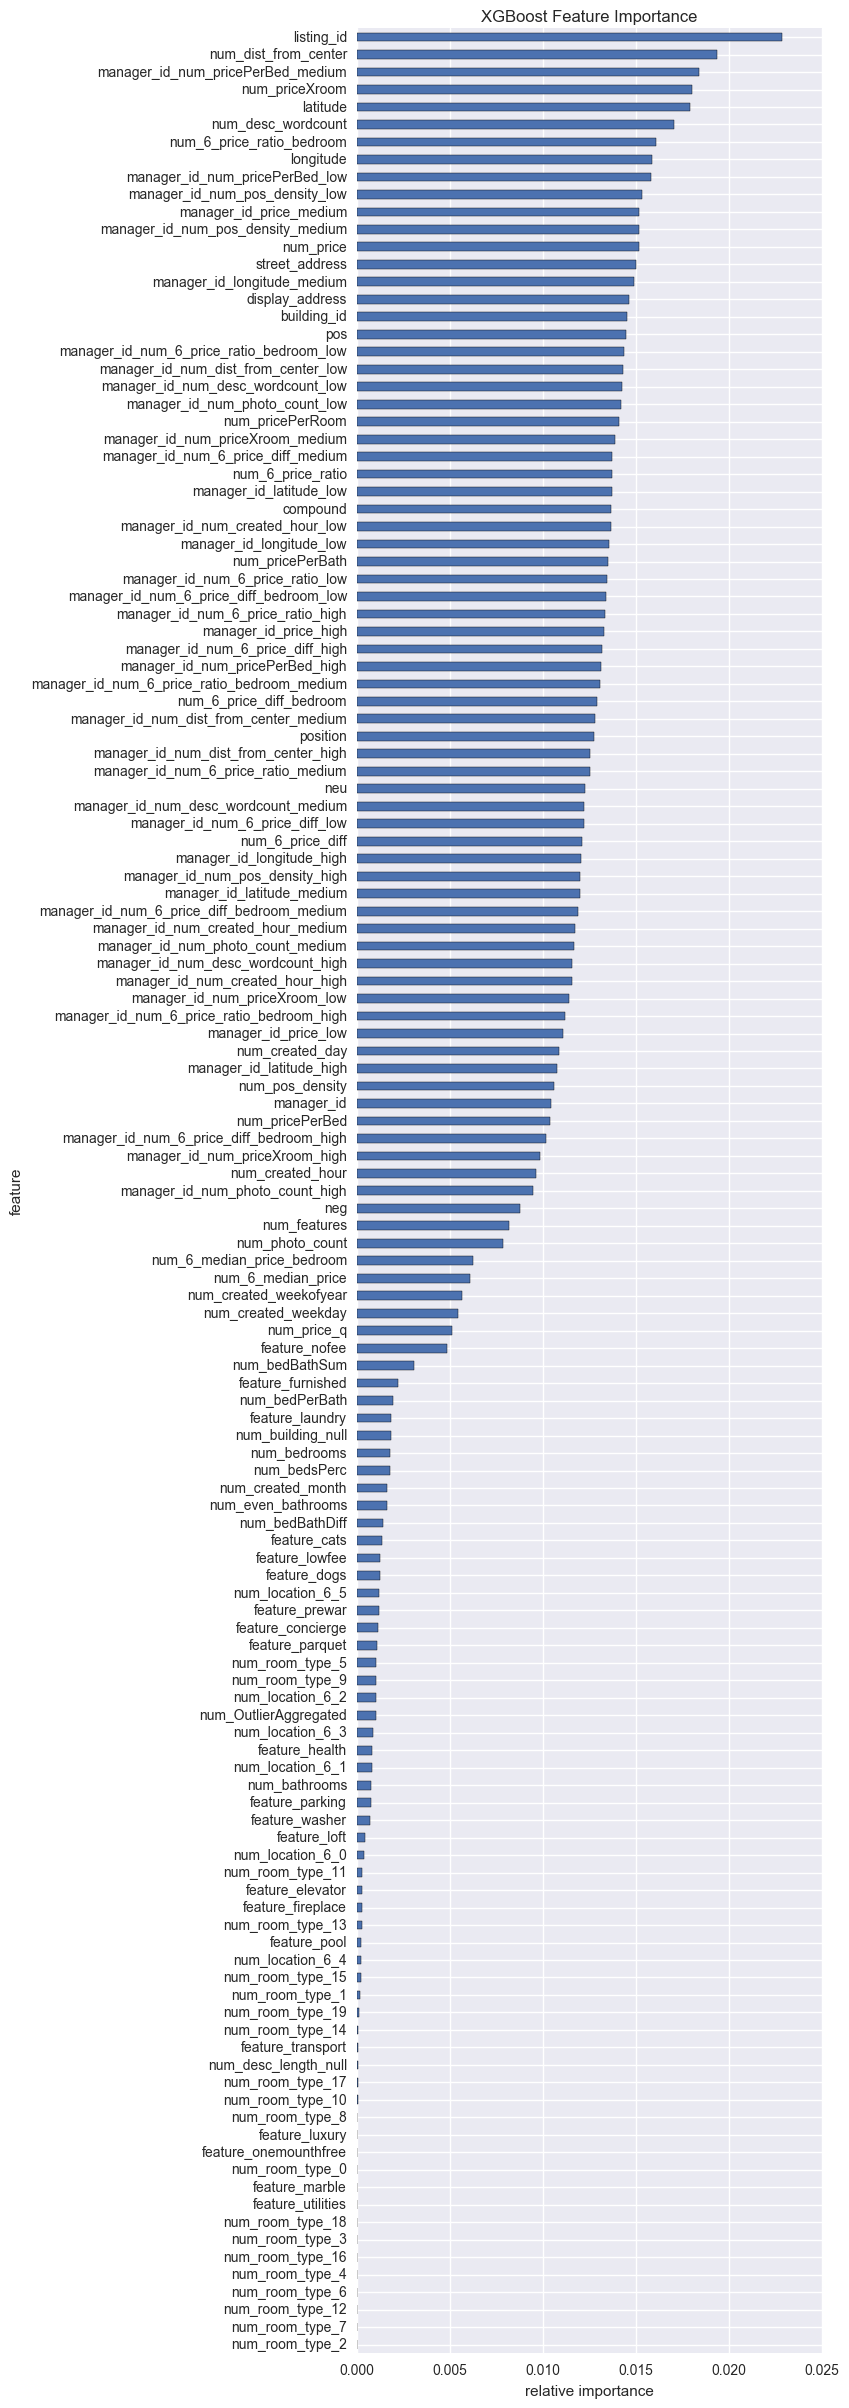

In [43]:
df = pd.DataFrame()
df['feature'] = features_to_use
df['fscore'] = rgr.feature_importances_
df['fscore'] = df['fscore'] / df['fscore'].sum()
df = df.sort_values(by='fscore')


# plt.figure()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 30))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [44]:
import xgbfir
xgbfir.saveXgbFI(rgr, feature_names=X_train.columns, OutputXlsxFile = '../FE/FI.xlsx')

In [48]:
data_path = "../input/"


train_X.to_csv(data_path + 'train_CV_statistics.csv',index=False)
test_X.to_csv(data_path + 'test_CV_statistics.csv',index=False)
np.savetxt(data_path + 'train_y_CV_statistics.csv',train_y, delimiter=",")

In [5]:
data_path = "../input/"
train_X = pd.read_csv(data_path + 'train_CV_statistics.csv')
test_X = pd.read_csv(data_path + 'test_CV_statistics.csv')
train_y = np.ravel(pd.read_csv(data_path + 'train_y_CV_statistics.csv',header=None))
sub_id = test_X.listing_id.astype('int32').values

# all_features = features_to_use + desc_sparse_cols + feat_sparse_cols
print train_X.shape, test_X.shape, train_y.shape

(49352, 133) (74659, 133) (49352L,)


In [6]:
data_path = "../input/"
train_X_0322 = pd.read_csv(data_path + 'train_BM_MB_add03052240.csv')
test_X_0322 = pd.read_csv(data_path + 'test_BM_MB_add03052240.csv')

In [8]:
feature_to_add = ['building_id_mean_med','building_id_mean_high', 'manager_id_mean_med','manager_id_mean_high','listing_id']

In [9]:
train_X = train_X.merge(train_X_0322[feature_to_add],on='listing_id', how='left')
test_X = test_X.merge(test_X_0322[feature_to_add],on='listing_id', how='left')

In [13]:
print cv_train(train_X,train_y)

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[82]	train-mlogloss:0.316212+0.00271234	test-mlogloss:0.531804+0.0070286

0.5318038


In [14]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, train_size=.80, random_state=2016)
rgr = xgb.XGBClassifier(
            objective='multi:softprob',
            seed = 0, # use a fixed seed during tuning so we can reproduce the results
            learning_rate = 0.2,
            n_estimators = 100000,
            max_depth= 6,
            nthread = -1,
            colsample_bytree = 0.3,
            subsample =0.7,
            silent = 1
        )
rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=20,
        verbose=20
    )

[0]	validation_0-mlogloss:0.980148
Will train until validation_0-mlogloss hasn't improved in 20 rounds.
[20]	validation_0-mlogloss:0.576293
[40]	validation_0-mlogloss:0.551853
[60]	validation_0-mlogloss:0.543142
[80]	validation_0-mlogloss:0.54011
[100]	validation_0-mlogloss:0.537351
[120]	validation_0-mlogloss:0.536406
Stopping. Best iteration:
[113]	validation_0-mlogloss:0.536182



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.7)

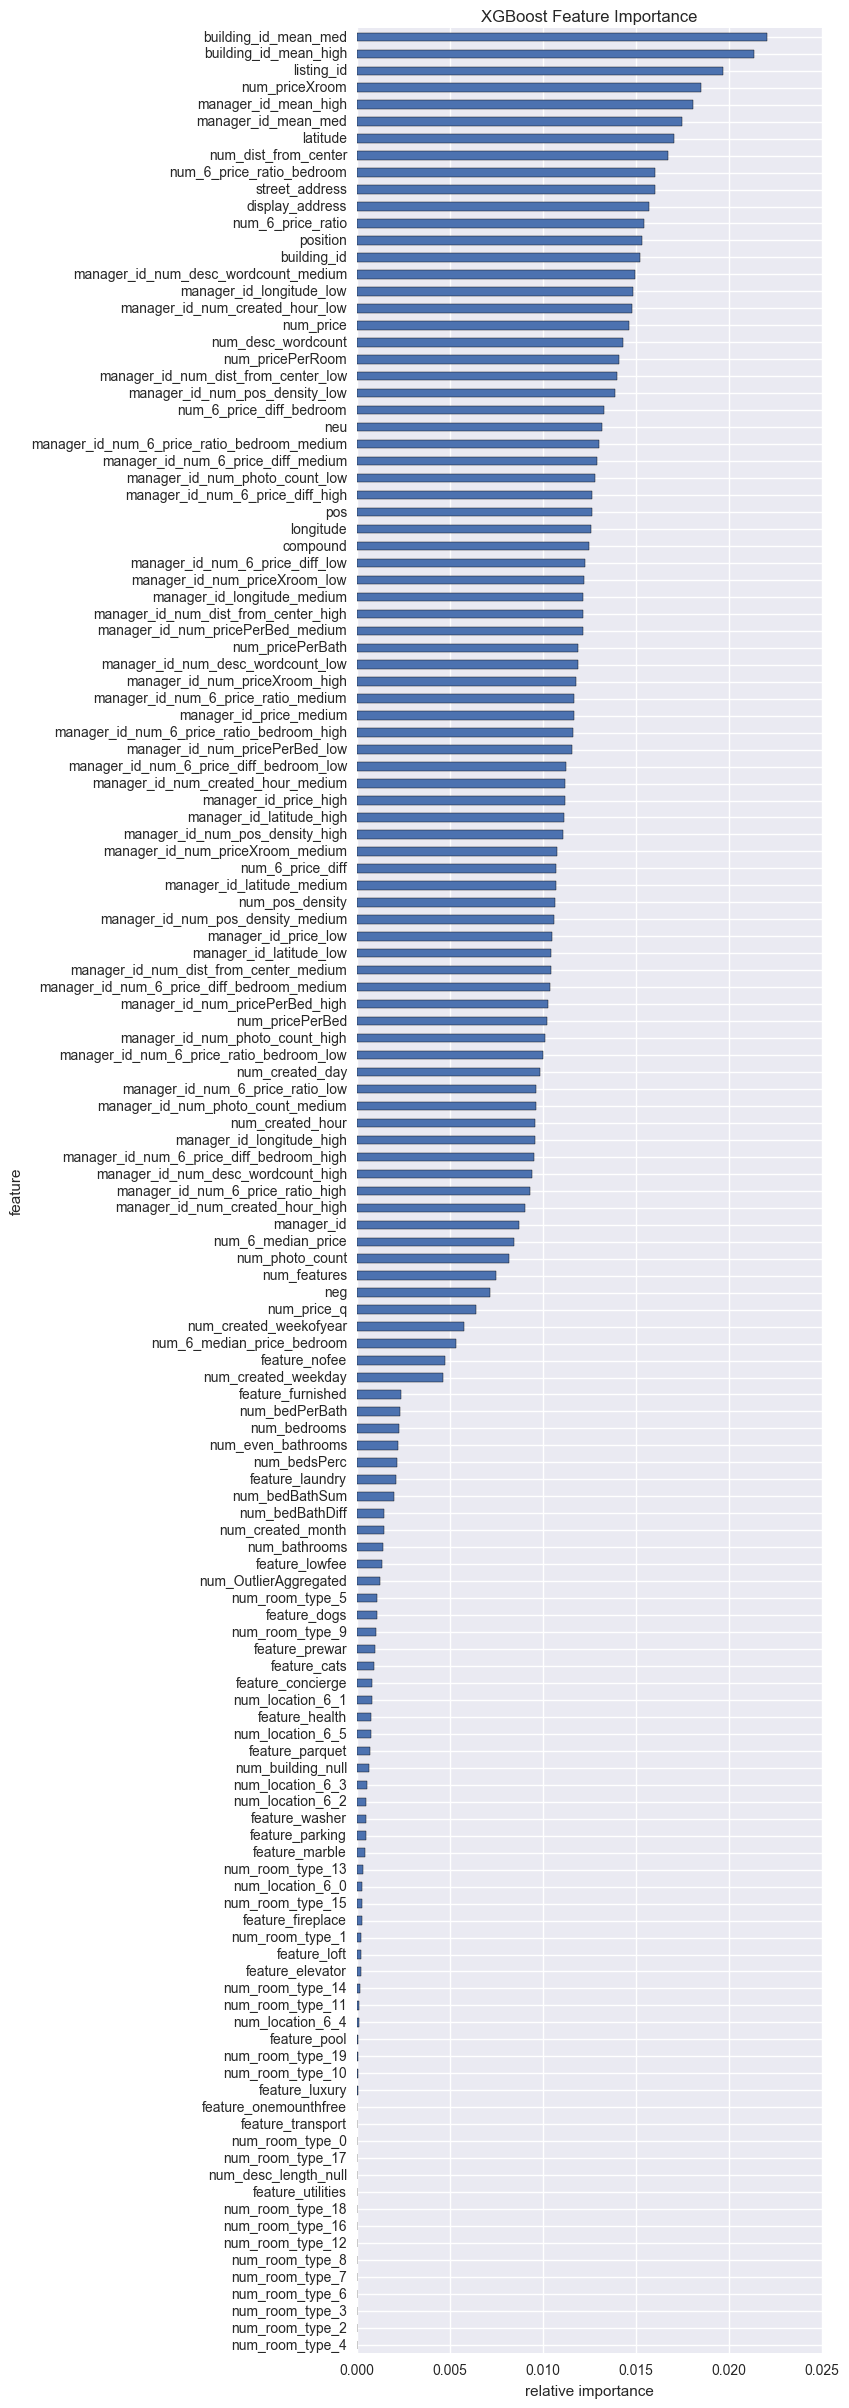

In [16]:
df = pd.DataFrame()
df['feature'] = train_X.columns
df['fscore'] = rgr.feature_importances_
df['fscore'] = df['fscore'] / df['fscore'].sum()
df = df.sort_values(by='fscore')


# plt.figure()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 30))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [17]:
train_X.to_csv(data_path + 'train_CV_statistics1.csv',index=False)
test_X.to_csv(data_path + 'test_CV_statistics1.csv',index=False)

In [29]:
# data_path = "../input/"
# train_X = pd.read_csv(data_path + 'train_CV_statistics1.csv')
# test_X = pd.read_csv(data_path + 'test_CV_statistics1.csv')
# train_y = np.ravel(pd.read_csv(data_path + 'train_y_CV_statistics.csv',header=None))
# sub_id = test_X.listing_id.astype('int32').values

# # all_features = features_to_use + desc_sparse_cols + feat_sparse_cols
# print train_X.shape, test_X.shape, train_y.shape

(49352, 137) (74659, 137) (49352L,)


In [30]:
feature_to_add = ['feature_1_month_free', 'feature_24/7_concierge',
       'feature_24/7_doorman', 'feature_24/7_doorman_concierge',
       'feature_actual_apt._photos', 'feature_air_conditioning',
       'feature_all_pets_ok', 'feature_all_utilities_included',
       'feature_assigned-parking-space', 'feature_attended_lobby',
       'feature_backyard', 'feature_balcony', 'feature_basement_storage',
       'feature_basketball_court', 'feature_bike_room',
       'feature_bike_storage', 'feature_billiards_room',
       'feature_billiards_table_and_wet_bar', 'feature_brand_new',
       'feature_breakfast_bar', 'feature_bright', 'feature_brownstone',
       'feature_building-common-outdoor-space', 'feature_business_center',
       'feature_cable/satellite_tv', 'feature_cable_ready',
       'feature_call/text_abraham_caro_@_917-373-0862',
       'feature_cats_allowed', 'feature_central_a/c', 'feature_central_ac',
       'feature_central_air', 'feature_chefs_kitchen',
       "feature_children's_playroom", 'feature_childrens_playroom',
       'feature_cinema_room', 'feature_city_view',
       'feature_close_to_subway', 'feature_closets_galore!',
       'feature_club_sun_deck_has_spectacular_city_and_river_views',
       'feature_cold_storage', 'feature_common_backyard',
       'feature_common_garden', 'feature_common_outdoor_space',
       'feature_common_parking/garage', 'feature_common_roof_deck',
       'feature_common_storage', 'feature_common_terrace',
       'feature_community_recreation_facilities',
       'feature_complimentary_sunday_brunch', 'feature_concierge',
       'feature_concierge_service', 'feature_condo_finishes',
       'feature_courtyard', 'feature_crown_moldings', 'feature_deck',
       'feature_deco_brick_wall', 'feature_decorative_fireplace',
       'feature_dining_room', 'feature_dishwasher', 'feature_dogs_allowed',
       'feature_doorman', 'feature_dry_cleaning_service',
       'feature_dryer_in_unit', 'feature_duplex', 'feature_duplex_lounge',
       'feature_eat-in_kitchen', 'feature_eat_in_kitchen',
       'feature_elegant_glass-enclosed_private_lounge_with_magnificent_river_views',
       'feature_elevator', 'feature_exclusive',
       'feature_exercise/yoga_studio', 'feature_exposed_brick',
       'feature_extra_room', 'feature_fireplace', 'feature_fireplaces',
       'feature_fitness_center', 'feature_fitness_room', 'feature_flex-2',
       'feature_flex-3', 'feature_free_wifi_in_club_lounge',
       'feature_ft_doorman', 'feature_full-time_doorman',
       'feature_full_service_garage',
       'feature_fully-equipped_club_fitness_center',
       'feature_fully__equipped', 'feature_furnished', 'feature_game_room',
       'feature_garage', 'feature_garbage_disposal', 'feature_garden',
       'feature_garden/patio', 'feature_granite_countertops',
       'feature_granite_kitchen', 'feature_green_building',
       'feature_guarantors_accepted', 'feature_gut_renovated',
       'feature_gym', 'feature_gym/fitness', 'feature_gym_in_building',
       'feature_hardwood', 'feature_hardwood_floors',
       'feature_health_club', 'feature_hi_rise',
       'feature_high-speed_internet', 'feature_high_ceiling',
       'feature_high_ceilings', 'feature_high_speed_internet',
       'feature_highrise', 'feature_housekeeping_service',
       'feature_in-unit_washer/dryer', 'feature_indoor_pool',
       'feature_intercom', 'feature_jacuzzi', 'feature_large_living_room',
       'feature_laundry', 'feature_laundry_&_housekeeping',
       'feature_laundry_in_building', 'feature_laundry_in_unit',
       'feature_laundry_on_every_floor', 'feature_laundry_on_floor',
       'feature_laundry_room', 'feature_light', 'feature_live-in_super',
       'feature_live-in_superintendent', 'feature_live/work',
       'feature_live_in_super', 'feature_loft', 'feature_lounge',
       'feature_lounge_room', 'feature_lowrise', 'feature_luxury_building',
       'feature_magnificent_venetian-style', 'feature_mail_room',
       'feature_marble_bath', 'feature_marble_bathroom',
       'feature_media_room', 'feature_media_screening_room',
       'feature_microwave', 'feature_midrise', 'feature_multi-level',
       'feature_new_construction', 'feature_newly_renovated',
       'feature_no_fee', 'feature_no_pets', 'feature_on-site_atm_machine',
       'feature_on-site_attended_garage', 'feature_on-site_garage',
       'feature_on-site_laundry',
#        'feature_on-site_lifestyle_concierge_by_luxury_attach\xc3\xa9',
       'feature_on-site_parking', 'feature_on-site_parking_available',
       'feature_on-site_parking_lot', 'feature_on-site_super',
       'feature_one_month_free', 'feature_outdoor_areas',
       'feature_outdoor_entertainment_space', 'feature_outdoor_pool',
       'feature_outdoor_roof_deck_overlooking_new_york_harbor_and_battery_park',
       'feature_outdoor_space', 'feature_package_room', 'feature_parking',
       'feature_parking_available', 'feature_parking_space',
       'feature_part-time_doorman', 'feature_party_room', 'feature_patio',
       'feature_penthouse', 'feature_pet_friendly', 'feature_pets',
       'feature_pets_allowed', 'feature_pets_on_approval',
       'feature_playroom', 'feature_playroom/nursery', 'feature_pool',
       'feature_post-war', 'feature_post_war', 'feature_pre-war',
       'feature_pre_war', 'feature_prewar', 'feature_private-balcony',
       'feature_private-outdoor-space', 'feature_private_backyard',
       'feature_private_balcony', 'feature_private_deck',
       'feature_private_garden',
       'feature_private_laundry_room_on_every_floor',
       'feature_private_outdoor_space', 'feature_private_parking',
       'feature_private_roof_deck', 'feature_private_roofdeck',
       'feature_private_terrace', 'feature_publicoutdoor',
       'feature_queen_size_bedrooms', 'feature_queen_sized_rooms',
       'feature_reduced_fee', 'feature_renovated',
       'feature_renovated_kitchen', 'feature_residents_garden',
       'feature_residents_lounge', 'feature_roof-deck',
       'feature_roof_access', 'feature_roof_deck',
       'feature_roof_deck_with_grills', 'feature_roofdeck',
       'feature_rooftop_deck', 'feature_rooftop_terrace',
       'feature_s/s_appliances', 'feature_sauna', 'feature_screening_room',
       'feature_separate_kitchen', 'feature_shared_backyard',
       'feature_shared_garden', 'feature_shares_ok',
       'feature_short_term_allowed', 'feature_simplex', 'feature_skylight',
       'feature_skylight_atrium', 'feature_southern_exposure',
       'feature_spa_services', 'feature_ss_appliances',
       'feature_stainless_steel', 'feature_stainless_steel_appliances',
       'feature_state-of-the-art_fitness_center', 'feature_storage',
       'feature_storage_available', 'feature_storage_facilities_available',
       'feature_storage_room', 'feature_sublet', 'feature_subway',
       'feature_sundeck', 'feature_swimming_pool', 'feature_tenant_lounge',
       'feature_terrace', 'feature_terraces_/_balconies',
       'feature_tons_of_natural_light', 'feature_valet',
       'feature_valet_parking', 'feature_valet_service',
       'feature_valet_services',
       'feature_valet_services_including_dry_cleaning',
       'feature_video_intercom', 'feature_view', 'feature_virtual_doorman',
       'feature_virtual_tour', 'feature_walk-in_closet', 'feature_walk-up',
       'feature_walk_in_closet', 'feature_walk_in_closet(s)',
       'feature_washer/dryer', 'feature_washer/dryer_hookup',
       'feature_washer/dryer_in-unit', 'feature_washer/dryer_in_building',
       'feature_washer/dryer_in_unit', 'feature_washer_&_dryer',
       'feature_washer_in_unit', 'feature_wheelchair_access',
       'feature_wheelchair_ramp', 'feature_wifi', 'feature_wifi_access',
       'feature_wood-burning_fireplace', 'feature_yard',
       'feature_yoga_classes','listing_id']

In [31]:
train_X = train_X.merge(train_X_0322[feature_to_add],on='listing_id', how='left')
test_X = test_X.merge(test_X_0322[feature_to_add],on='listing_id', how='left')

In [23]:
print cv_train(train_X,train_y)

Multiple eval metrics have been passed: 'test-mlogloss' will be used for early stopping.

Will train until test-mlogloss hasn't improved in 20 rounds.
Stopping. Best iteration:
[85]	train-mlogloss:0.315841+0.00241469	test-mlogloss:0.532259+0.00756141

0.5322592


In [24]:
X_train, X_val, y_train, y_val = train_test_split(train_X, train_y, train_size=.80, random_state=2016)
rgr = xgb.XGBClassifier(
            objective='multi:softprob',
            seed = 0, # use a fixed seed during tuning so we can reproduce the results
            learning_rate = 0.2,
            n_estimators = 100000,
            max_depth= 6,
            nthread = -1,
            colsample_bytree = 0.3,
            subsample =0.7,
            silent = 1
        )
rgr.fit(
        X_train,y_train,
        eval_set=[(X_val,y_val)],
        eval_metric='mlogloss',
        early_stopping_rounds=20,
        verbose=20
    )

[0]	validation_0-mlogloss:0.974572
Will train until validation_0-mlogloss hasn't improved in 20 rounds.
[20]	validation_0-mlogloss:0.574991
[40]	validation_0-mlogloss:0.55051
[60]	validation_0-mlogloss:0.543143
[80]	validation_0-mlogloss:0.538972
[100]	validation_0-mlogloss:0.537383
[120]	validation_0-mlogloss:0.537601
Stopping. Best iteration:
[102]	validation_0-mlogloss:0.537009



XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.3,
       gamma=0, learning_rate=0.2, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=100000, nthread=-1,
       objective='multi:softprob', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=1, subsample=0.7)

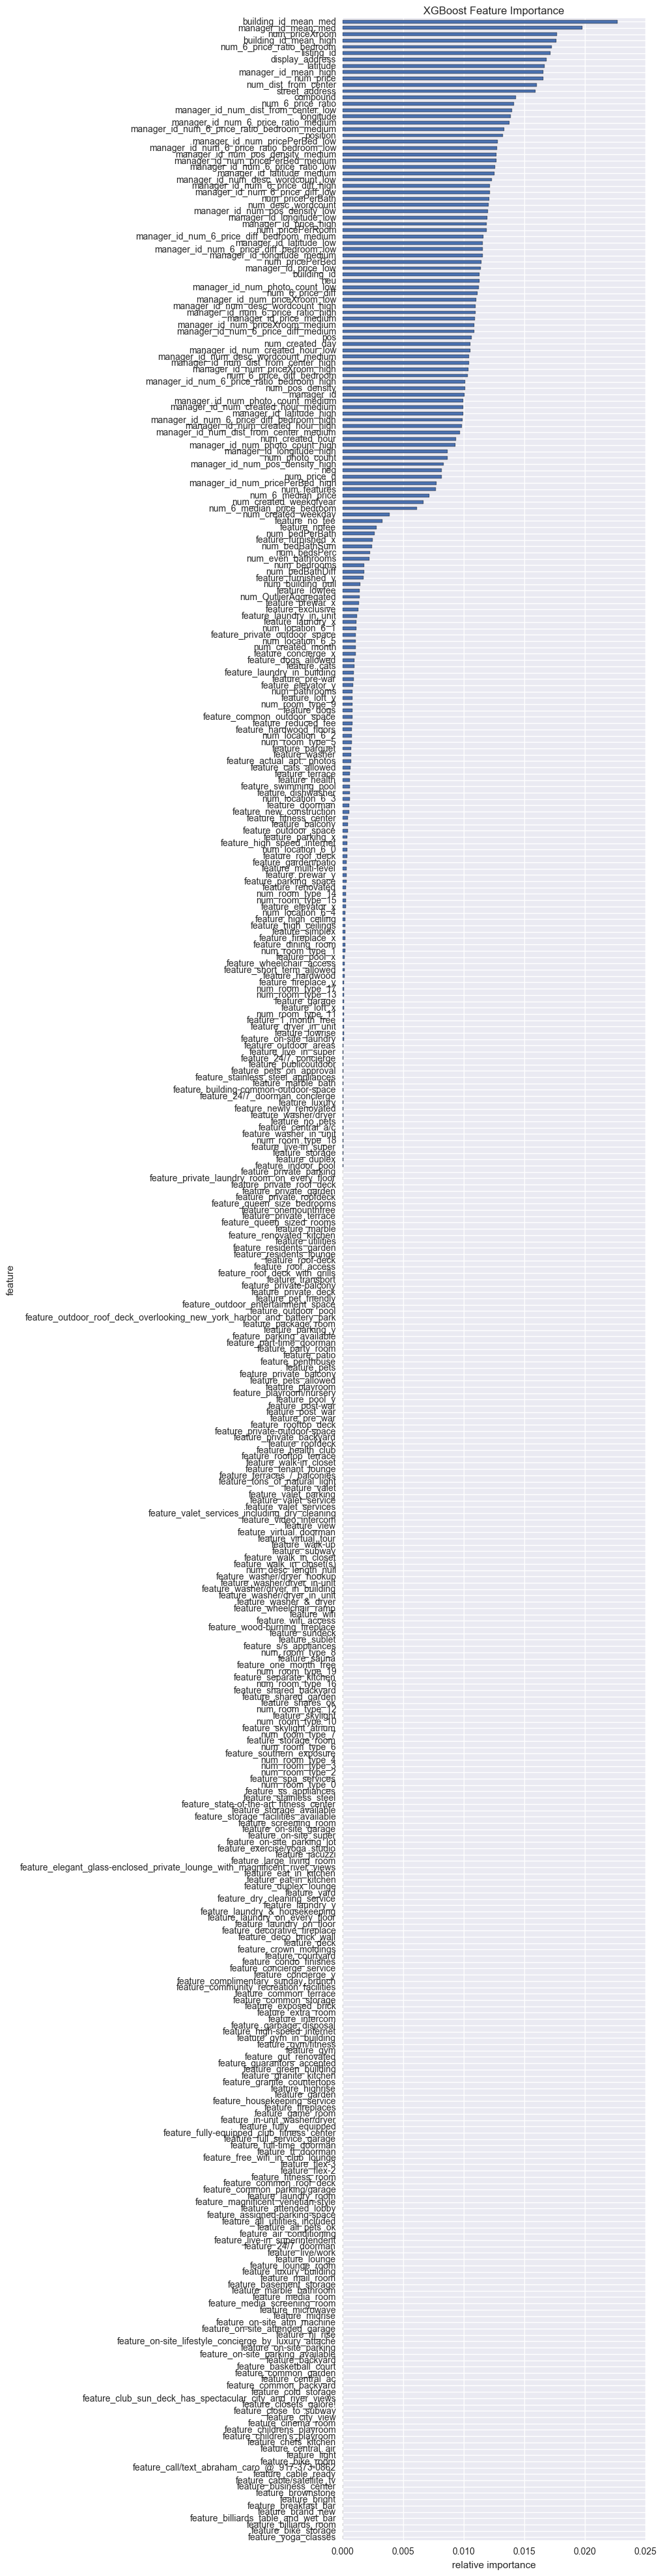

In [27]:
df = pd.DataFrame()
df['feature'] = X_train.columns.values
df['fscore'] = rgr.feature_importances_
df['fscore'] = df['fscore'] / df['fscore'].sum()
df = df.sort_values(by='fscore')


# plt.figure()
df.plot(kind='barh', x='feature', y='fscore', legend=False, figsize=(6, 50))
plt.title('XGBoost Feature Importance')
plt.xlabel('relative importance')

In [32]:
train_X.to_csv(data_path + 'train_CV_statistics2.csv',index=False)
test_X.to_csv(data_path + 'test_CV_statistics2.csv',index=False)